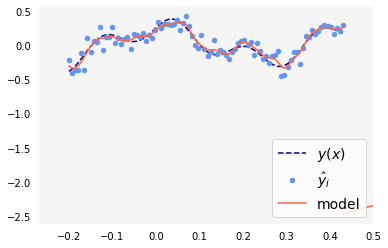

In [41]:
import numpy as np
import pandas as pd
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.special import erfinv
from scipy.optimize import minimize_scalar
import egrss 
import time
from scipy import integrate

# Generate data with noise level sigma
N = 90
sigma = 0.1
a, b = -0.2, 0.43
p = 2  # degree of splines
xi = (b-a) ** (2 * p - 1)
x = np.linspace(a,b,N)
xextra = np.linspace(0.43,0.5,10)

# Function 
def y(x):
    return 0.25*np.cos(4*np.pi *x) + 0.15*np.sin(12* np.pi *x) + 0.2 * x

np.random.seed(1)
yhat = y(x) + sigma * np.random.normal(loc = 0, scale = 1, size = x.shape)
yhatextra = y(xextra) + sigma * np.random.normal(loc = 0, scale = 1, size = xextra.shape)

def smoothing_spline_reg(Ut,Wt,z,yhat,obj = 'nothing'):
    p,n = Ut.shape
    B   = np.zeros((n,p))
    for k in range(p):
        B[:,k] = egrss.trsv(Ut,Wt,Ut[k,:].T, z,'N') 
    Q, R     = qr(B)
    c        = egrss.trsv(Ut,Wt,yhat,z,'N')
    c        = np.dot(Q.T,c)
    d        = solve(R[0:p,0:p],c[0:p])
    c[0:p]   = 0
    c        = egrss.trsv(Ut,Wt,np.dot(Q,c), z,'T')
    if obj == 'nothing':
        return c, d
    elif obj == 'gml': 
        log_glm  = np.log(np.dot(yhat.T,c)) + 2.0 / (n-p ) * (np.sum(np.log(z),axis = 0) + np.sum( np.log(np.abs(np.diag(R[0:p,0:p])))))
        return c, d, log_glm
    else:
        raise Exception("Unknown objective")
        
def min_GCV(N, a, b, p, yhat, method, usage,  bounds = 'nothing', q = 'nothing'):
    xi = (b-a) ** (2 * p - 1) 
    x = np.linspace(a,b,N)

    def GCV(q):
        lam = 1/np.power(10,q)
        Ut, Vt = egrss.generators((x-a)/(b-a),p) 
        Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
        alpha ,d  = smoothing_spline_reg(Ut,Wt,z,yhat) 
        Linv = egrss.trtri2(Ut,Wt,z)
        LinvF = np.zeros([N,p])
        for i in range(p):
            LinvF[:,i] = egrss.trsv(Ut,Wt,Ut[i,:], z,'N') 
        Q,R = np.linalg.qr(LinvF, mode = 'reduced')

        LinvTQ = np.zeros([N,p])
        for k in range(p):
            LinvTQ[:,k] = egrss.trsv(Ut,Wt,Q[:,k],c=z,trans='T')

        return np.asscalar(np.log(N) + 2*np.log(np.linalg.norm(alpha))- 2*np.log(np.linalg.norm(Linv,'fro')**2 - np.linalg.norm(LinvTQ,'fro')**2))
    
    if usage == 'min':
        min_point = minimize_scalar(GCV, bounds = bounds, method=method )
        return min_point
    
    elif usage == 'evaluate':
        res = np.zeros(len(q))
        for i in range(len(q)):
            res[i] = GCV(q[i])
        return res

def phi(xextra, k, a):
    value = ((xextra-a)**(k-1))/np.math.factorial(k-1)
    return value


def extrapolate(x, xextra, a, b, c, d, p, n):
    value = 0

    for i in range(p):
            value += d[i]*phi(xextra, i+1, a)
    
    for i in range(n):
        f = lambda u:(max(0,xextra-u)**(p-1)/np.math.factorial(p-1))*(max(0,x[i]-u)**(p-1)/np.math.factorial(p-1))
        value += c[i]*integrate.quad(f,a,b)[0] 
    
    return value

lam = 1/np.power(10,8)
Ut, Vt = egrss.generators((x-a)/(b-a),p)
Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
c,d    = smoothing_spline_reg(Ut,Wt,z,yhat)
yextra = np.zeros([10])
for i in range(len(xextra)):
    yextra[i] = extrapolate(x, xextra[i], a, b, c, d, p, n = 90)




fig2 = plt.figure()
plt.plot(x,y(x),'--',color = 'navy', linewidth=1.5)
plt.plot(x,yhat,'o',markersize = 4.5, color = 'cornflowerblue')
plt.plot(x,yhat-N*lam/xi*c ,color = 'tomato', linewidth=1.5)
plt.xlim([a-0.07,b+0.07])
plt.tick_params(left=False, bottom = False, right = False, top = False)
plt.legend(['$y(x)$', '$\hat{y}_i$','model'], numpoints = 1, prop = {'size': 14}, loc = 'lower right')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# plt.title('Fit - pertubating a point', fontsize = 18)
plt.plot(xextra, yextra, '-', color = 'tomato')
plt.show()


In [37]:
yhat[-1]

0.286041337113107

In [3]:
def pertubation(datapoint, yhat, yhatextra, n_fit, quantile):
    """
    Making pertubations and fit
    """
    if datapoint == 'left':
        datapoint = 0
    elif datapoint == 'center':
        datapoint = int(len(yhat)/2)
    elif datapoint == 'right':
        datapoint = len(yhat)-1
    allfit = pd.DataFrame(index=range(N),columns=range(n_fit+1))
    c_all = pd.DataFrame(index=range(N),columns=range(n_fit+1))
    d_all = pd.DataFrame(index=range(p),columns=range(n_fit+1))
    extrapolation_all = pd.DataFrame(index=range(len(yhatextra)),columns=range(n_fit+1))
    val = yhat[datapoint]
    Ut, Vt = egrss.generators((x-a)/(b-a),p)

    for i in range(n_fit):
        yhat[datapoint] += sigma* np.random.normal(loc = 0, scale = 1, size = 1)

        # Finding the optimal lambda - GML
        res_GML = min_GCV(N, a, b, p, yhat, 'bounded', 'min',  (1,13))
        lam = 1/np.power(10,res_GML.x) # 8.5e-8
        Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
        c,d    = smoothing_spline_reg(Ut,Wt,z,yhat)
        modelfit = yhat-N*lam/xi*c
        modelfitdf = pd.DataFrame(modelfit)
        allfit[i] = modelfitdf
        c_all[i] = c
        d_all[i] = d
        
        # Extrapolation
        for j in range(len(yhatextra)):
            # extrapolation_all[j,i] = extrapolate(yhatextra[j], yhat, a, b, c, d, p, N)
            extrapolation_all = pd.DataFrame(extrapolation_all)
        
        yhat[datapoint] = val
    
    max_val = allfit.quantile(q=1-(1-quantile)/2, axis=1, numeric_only=True)
    min_val = allfit.quantile(q=(1-quantile)/2, axis=1, numeric_only=True)
    max_extra = extrapolation_all.quantile(q=1-(1-quantile)/2, axis=1, numeric_only=True)
    min_extra = extrapolation_all.quantile(q=(1-quantile)/2, axis=1, numeric_only=True)

    return min_val, max_val, allfit, datapoint, yhat, max_extra, min_extra, extrapolation_all

<ipython-input-34-2b9ea046f3e9>:68: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(N) + 2*np.log(np.linalg.norm(alpha))- 2*np.log(np.linalg.norm(Linv,'fro')**2 - np.linalg.norm(LinvTQ,'fro')**2))


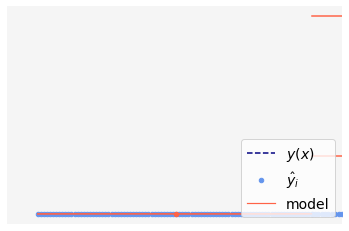

In [38]:
min_val, max_val, allfit, datapoint, yhat, max_extra, min_extra, extrapolation_all = pertubation(datapoint='center', yhat=yhat, yhatextra=yhatextra, n_fit=200, quantile=0.95)
    

# Plotting the model generated with lambda_GML
fig2 = plt.figure()
plt.plot(x,y(x),'--',color = 'navy', linewidth=1.5)
plt.plot(x,yhat,'o',markersize = 4.5, color = 'cornflowerblue')
plt.plot(x,max_val,color = 'tomato', linewidth=1.2)
plt.plot(x[datapoint], yhat[datapoint], 'o',markersize=4.5, color='tomato')
plt.fill_between(x, min_val, max_val, color='grey', alpha=0.5)
plt.plot(xextra,yhatextra,'o',markersize = 4.5, color = 'cornflowerblue')
plt.plot(xextra,max_extra, color='tomato')
plt.plot(xextra,min_extra, color='tomato')
plt.plot(x,min_val,color = 'tomato', linewidth=1.2)
plt.xticks([])
plt.yticks([])
plt.xlim([a-0.07,b+0.07])
plt.tick_params(left=False, bottom = False, right = False, top = False)
plt.legend(['$y(x)$', '$\hat{y}_i$','model'], numpoints = 1, prop = {'size': 14}, loc = 'lower right')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# plt.title('Fit - pertubating a point', fontsize = 18)
plt.show()
fig2.savefig("pertubation_left.pdf", bbox_inches='tight')

In [39]:
extrapolation_all

,0,1,2,3,4,5,6,7,8,9,...,"(0, 199)","(1, 199)","(2, 199)","(3, 199)","(4, 199)","(5, 199)","(6, 199)","(7, 199)","(8, 199)","(9, 199)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1241.326572,818.66602,602.581981,523.747283,924.185475,882.304763,848.151523,1132.446539,1053.42068,1714.600369


In [8]:
phi(x, 1, a)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])